# EDA: MIMIC-III ICU Readmissions

In [56]:
import psycopg2
from psycopg2 import extras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

In [33]:
def cursor_connect(cursor_factory=None):
    """
    Connects to the DB and returns the connection and cursor, ready to use.
    
    Parameters
    ----------
    cursor_factory : psycopg2.extras
    
    Returns
    -------
    (psycopg2.extensions.connection, psycopg2.extensions.cursor)
        A tuple of (psycopg2 connection, psycopg2 cursor).
    """
    #DB connection
    conn = psycopg2.connect(dbname="mimic", user="mimic", host="localhost", port="2345",
                            password="oNuemmLeix9Yex7W")
    if not cursor_factory:
        cur = conn.cursor()
    else:
        cur = conn.cursor(cursor_factory=cursor_factory)
    return conn, cur

def exec_query(query, curs_dict=True):
    """
    Execute query and returns the SQL output.
    
    Parameters
    ----------
    query: string containing SQL SELECT command
    curs_dict: dict cursor factory (output is dict)
    
    Returns
    -------
    rows: list of rows/records (SQL output)
    """
    if curs_dict == True: 
        conn, cur = cursor_connect(psycopg2.extras.DictCursor)
    else:
        conn, cur = cursor_connect()
    cur.execute(query)
    rows = cur.fetchall()
    return rows

## Patient Hospital Admissions
Brief high-level exploration of general hospital admissions.

In [3]:
# queries
q_nhadm = """SELECT COUNT(DISTINCT hadm_id) FROM admissions;"""
q_nhadm_patient = """SELECT COUNT(DISTINCT subject_id) FROM admissions;"""
q_nicu = """SELECT COUNT(*) FROM icustays;"""
q_icu_hadm = """SELECT COUNT(DISTINCT hadm_id) FROM icustays;"""
q_nicu_patient = """SELECT COUNT(DISTINCT subject_id) FROM icustays;"""
q_nicu_readm = """SELECT COUNT(*) FROM 
        (SELECT subject_id, COUNT(icustay_id) AS n_icustays
        FROM icustays
        GROUP BY subject_id) AS sub_q
    WHERE n_icustays > 1;"""

# Execute Queries - Output
n_hadm = exec_query(q_nhadm)
n_hadm_patient = exec_query(q_nhadm_patient)
n_icustay = exec_query(q_nicu)
n_icu_hadm = exec_query(q_icu_hadm)[0][0]
n_icu_patient = exec_query(q_nicu_patient)
n_nicu_readm = exec_query(q_nicu_readm)

print "Hospital Admissions:"
print "Number of Unique Hospital Admissions = ", n_hadm[0][0]
print "Number of Unique Patients Admitted = ", n_hadm_patient[0][0]
print "\nICU stays:"
print "Number of Unique ICU stays = ", n_icustay[0][0]
print "Number of Unique Hospital Admissions involving an ICU Stay = ", n_icu_hadm
print "Number of Unique Patients with ICU stays = ", n_icu_patient[0][0]
print "Number of Unique Patients with ICU Readmissions", n_nicu_readm[0][0]

Hospital Admissions:
Number of Unique Hospital Admissions =  58976
Number of Unique Patients Admitted =  46520

ICU stays:
Number of Unique ICU stays =  61532
Number of Unique Hospital Admissions involving an ICU Stay =  57786
Number of Unique Patients with ICU stays =  46476
Number of Unique Patients with ICU Readmissions 8755


n<sub>hadm</sub> < n<sub>icustay</sub> because a patient may have *multiple ICU stays* within a unique hospital admission.

**Key Inferences:**
  * Majority of patients admitted into the hospital had at least 1 ICU stay (99%), though only 18% were readmitted into the ICU multiple times (> 1 icu stay).
  * 98% of unique hospital admissions involved at least one ICU stay.


### Patient Age at time of Hospital Admission
**Notes**: 
  * May have multiple counts for patients as patients can be admitted more than once.
  * MIMIC-III adjusts age of patients > 89 years old (+210 yrs)

In [4]:
# age of patients < 90
q_age_hadm1 = """SELECT a.subject_id,
    FLOOR((a.admittime::date - p.dob::date)/365.0) AS age
    FROM admissions as a
    INNER JOIN patients as p
    ON a.subject_id = p.subject_id
    WHERE FLOOR((a.admittime::date - p.dob::date)/365.0) < 90;"""

# adjusted age of patients > 89
q_age_hadm2 = """SELECT a.subject_id,
    FLOOR((a.admittime::date - p.dob::date)/365.0) -210 AS age
    FROM admissions as a
    INNER JOIN patients as p
    ON a.subject_id = p.subject_id
    WHERE FLOOR((a.admittime::date - p.dob::date)/365.0) > 89;"""

age_hadm1 = exec_query(q_age_hadm1, False)
age_hadm2 = exec_query(q_age_hadm2, False)
df_age_hadm1 = pd.DataFrame(age_hadm1, columns=['subjectid', 'age'])
df_age_hadm2 = pd.DataFrame(age_hadm2, columns=['subjectid', 'age'])

df_age_hadm = pd.concat([df_age_hadm1, df_age_hadm2])
df_age_hadm

,subjectid,age
0,88,28
1,91,81
2,94,74
3,94,75
4,95,44
5,96,38
6,102,0
7,103,60
8,103,60
9,105,35


#### Histogram: Patients Age at Hospital Admission
Frequency of patients' age during time of hospital admission.

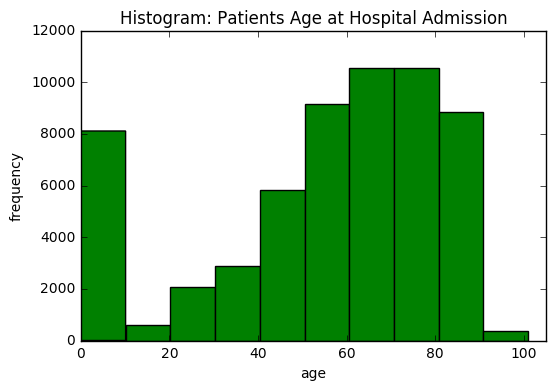

In [36]:
plt.hist(df_age_hadm.age.astype(np.int), color='g')
plt.xlabel('age')
plt.ylabel('frequency')
plt.xlim([0,105])
plt.title('Histogram: Patients Age at Hospital Admission')
plt.show()

In [38]:
print "HADM Average Age = %.2f yrs" % df_age_hadm.age.astype(np.int).mean()
print "HADM Median Age = %.2f yrs" % df_age_hadm.age.astype(np.int).median()

print "Standard Deviation = %.2f yrs" % df_age_hadm.age.astype(np.int).std()

HADM Average Age = 54.74 yrs
HADM Median Age = 61.00 yrs
Standard Deviation = 27.15 yrs


The age of patients at the time of hospital admission has a *left-skewed* distribution, where the left tail is longer. Likewise, the mean (54.74 yrs) < median (61.00 yrs).

We expect the age of patients to be mostly about 27-28 years from the mean (54.74 yrs).

**Outliers**: Newborns (age: 0 yrs) were included in the dataset and present an outlier. No adolescents < 14 years old were included.

### N<sub>icustays</sub> per Hospital Admission
Explore the frequency of icu stays within each hospital admission.

In [39]:
#query 
q_hadm_icu = """SELECT icu.hadm_id, COUNT(icu.icustay_id) AS n_icustay
FROM 
    admissions as adm 
INNER JOIN 
    icustays as icu
ON adm.hadm_id = icu.hadm_id
GROUP BY icu.hadm_id;
"""
# Query output
n_icu_hadm = exec_query(q_hadm_icu, False)
df_icu_hadm = pd.DataFrame(n_icu_hadm, 
                           columns = ['hadm_id', 'n_icustay'])
print "Max ICU stays per HAdm = %.2f" % df_icu_hadm.n_icustay.max()
print "Average ICU stay per HAdm = %.2f" % df_icu_hadm.n_icustay.mean()

Max ICU stays per HAdm = 7.00
Average ICU stay per HAdm = 1.06


#### Histogram of ICU Admissions
Frequency of ICU stays per unique hospital admission

In [8]:
df_icu_hadm.n_icustay.value_counts()

1    54526
2     2865
3      326
4       54
5       10
6        3
7        2
Name: n_icustay, dtype: int64

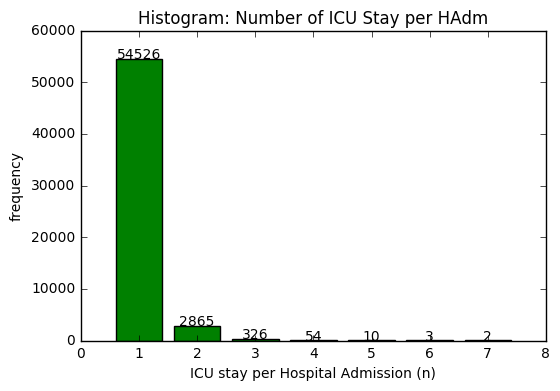

In [40]:
plt.bar(df_icu_hadm.n_icustay.value_counts().index, 
        df_icu_hadm.n_icustay.value_counts().values,
       align='center', color='green')
plt.xlabel('ICU stay per Hospital Admission (n)')
plt.ylabel('frequency')
for i, val in zip(df_icu_hadm.n_icustay.value_counts().index, df_icu_hadm.n_icustay.value_counts().values):
    plt.text(i, val, str(val), ha='center')
plt.title('Histogram: Number of ICU Stay per HAdm')
plt.show()

**Conclusions**:
  * Each hospital admission primarily consisted of 1 ICU stay. Thus, suggesting low frequency of ICU readmission.

## ICU Stay
Explore general ICU stay, not necessarily ICU readmission.

### Hospital Admission LOS vs. n<sub>icustay</sub>
Extract Hospital Admission (`hadm`) length of stay and explore potential bivariate relationships between it and the number of ICU stays (`icustay`).
  * HAdm `LOS` is extracted from: `admissions.dischtime - admissions.admittime`

In [10]:
# query
q_hadmlos_icu = """SELECT EXTRACT(day FROM (dischtime-admittime)) 
AS adm_los, n_icustays
FROM admissions as a
INNER JOIN
    (SELECT hadm_id, COUNT(*) AS n_icustays FROM icustays 
    GROUP BY hadm_id) AS i
ON a.hadm_id = i.hadm_id;"""

# Query output
hadmlos_icu = exec_query(q_hadmlos_icu, False)
df_hadmlos_icu = pd.DataFrame(hadmlos_icu, 
                              columns=['adm_los', 'n_icustay'])

df_hadmlos_icu.sort_values('n_icustay', ascending=False)

,adm_los,n_icustay
38139,84.0,7
41524,70.0,7
15792,140.0,6
54253,105.0,6
32359,108.0,6
15700,65.0,5
18718,118.0,5
23867,72.0,5
22346,107.0,5
36797,71.0,5


In [41]:
df_hadmlos_icu.describe()

,adm_los,n_icustay
count,57786.000000,57786.000000
mean,9.699218,1.064825
std,12.524860,0.285775
min,0.000000,1.000000
25%,3.000000,1.000000
50%,6.000000,1.000000
75%,11.000000,1.000000
max,294.000000,7.000000


**Conclusions**:
  * Hospital admissions involving at least 1 ICU stay typically have a `LOS` 12-13 days within the mean of 9.7 days.
  * The average n<sub>icu stay</sub> per hospital admission is 1.06 stays.

#### Correlation: Hospital Admission LOS vs.  n<sub>icu stays</sub>

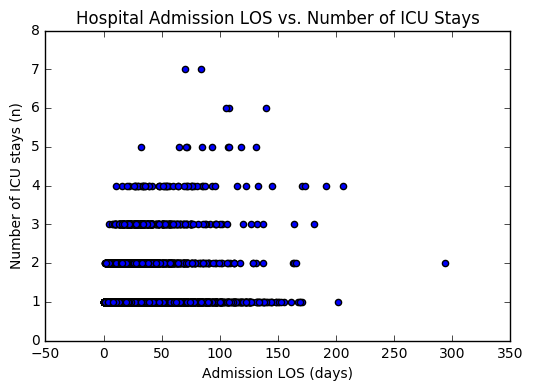

In [42]:
plt.scatter(df_hadmlos_icu.adm_los, df_hadmlos_icu.n_icustay)
plt.xlabel('Admission LOS (days)')
plt.ylabel('Number of ICU stays (n)')
plt.title('Hospital Admission LOS vs. Number of ICU Stays')
plt.show()

In [59]:
df_hadmlos_icu.corr(method='pearson')
# stats.pearsonr(df_hadmlos_icu.adm_los, df_hadmlos_icu.n_icustay)

,adm_los,n_icustay
adm_los,1.000000,0.323448
n_icustay,0.323448,1.000000


According to the visualization, there appears to be no clear correlation between the length of each hospital admission and its respective n<sub>ICU stay</sub>. Though, there appears to be a **weak positive correlation** with a Pearson correlation coefficient of 0.32.

**Other Conclusions**:
  * Most admissions involve a relatively *low* hospital admission LOS & number of ICU stay. This may be due to high costs of ICU beds, urging clinicians to discharge patients from the ICU.

### ICU Length of Stay (`icustays.los`)
Expore LOS within the ICU  
(Note: an ICU stay is defined by > 24 hours from last admission into the ICU).

In [12]:
# query
iculos = exec_query("""SELECT los FROM icustays;""")

# Query output
iculos_arr = np.array(iculos)[:,0].astype(np.float)
iculos_arr = np.rint(iculos_arr)
iculos_df = pd.Series(iculos_arr).dropna()

print "ICU LOS Mean = %.2f days" % iculos_df.mean()
print "ICU LOS Median = %.2f days" % iculos_df.median()

ICU LOS Mean = 4.91 days
ICU LOS Median = 2.00 days


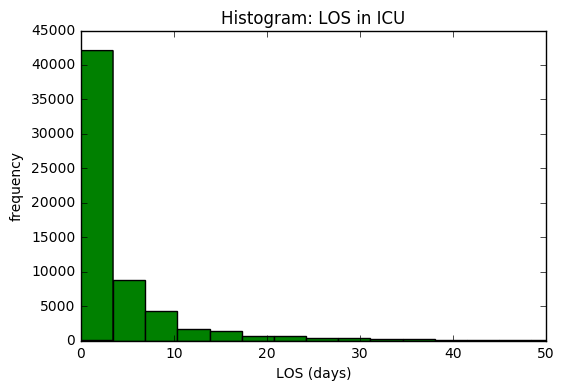

In [46]:
iculos = exec_query("""SELECT los FROM icustays;""")

iculos_arr = np.array(iculos)[:,0].astype(np.float)
iculos_arr = np.rint(iculos_arr)
iculos_df = pd.Series(iculos_arr).dropna()

# plot
plt.hist(iculos_df, color='g', bins=50)
plt.xlabel('LOS (days)')
plt.ylabel('frequency')
plt.xlim([0,50])
plt.title('Histogram: LOS in ICU')
plt.show()

`LOS` in the ICU has a *right-skewed* distribution, where the right tail is longer. Thus, indicating that the mean (4.91 days) > median (2.00 days).

### Frequency of Admitted First Care Units
Determine the frequency of ICU admission for each care ICU unit.

In [47]:
# query
q_firstcu = """SELECT first_careunit, COUNT(*) AS n_careunit 
FROM icustays 
GROUP BY first_careunit;"""

# Query output
first_cu = exec_query(q_firstcu, False)

df_fcu = pd.DataFrame(first_cu, columns=['first_cu', 'n_patient'])
fcu_perc = ((df_fcu.n_patient / df_fcu.n_patient.sum()) * 100).round(decimals=2) # extract new feature
fcu_perc.name = 'ficu_perc' # change series name
df_fcu = pd.concat([df_fcu, fcu_perc], 
          axis=1) # concatenate column to df

df_fcu.sort_values('n_patient', ascending=False)       

,first_cu,n_patient,ficu_perc
0,MICU,21088,34.27
3,CSRU,9855,16.02
1,SICU,8891,14.45
4,NICU,8100,13.16
5,CCU,7726,12.56
2,TSICU,5872,9.54


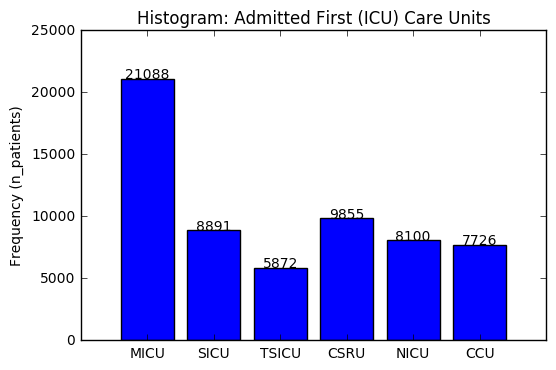

In [48]:
plt.bar(range(6), df_fcu.n_patient, align='center')
plt.ylabel('Frequency (n_patients)')
plt.xticks(range(6), df_fcu.first_cu)
plt.title('Histogram: Admitted First (ICU) Care Units')
for i, val in zip(range(6), df_fcu.n_patient):
    plt.text(i, val, str(val), ha='center')
plt.show()

`MICU` (Mobile ICU), such as specialized ambulance care, are by the far the most frequently ICU type used for the patients' first admission into the ICU. 

**Ranking**:
  1. Mobile Intensive Care Unit (`MICU`)
  2. Cardiac Surgery Recovery Unit (`CSRU`)
  3. Surgical Intensive Care Unit (`SICU`)
  4. Neonatal Intensive Care Unit (`NICU`)
  5. Cardiac Care Unit (`CCU`)
  6. Trauma Surgical Intensive Care Unit (`TSICU`)


## ICU Readmissions
Expore ICU readmissions.
n<sub>ICU readmissions</sub> = 8755

### Identify Patients that have been readmitted into the ICU
Each unique patient (`subject_id`) & their corresponding number of icustays (readmission == n<sub>ICU stay</sub> > 1).

In [16]:
# query
q_icupat="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

# Query output
icu_pat = exec_query(q_icupat, False)
df_icu_pat = pd.DataFrame(icu_pat, columns=['patientid', 'n_icustay'])
df_icu_pat

,patientid,n_icustay
0,7,2
1,17,2
2,21,2
3,23,2
4,34,2
5,36,3
6,41,2
7,61,2
8,67,2
9,68,3


In [17]:
df_icu_pat.n_icustay.mean()

2.7197030268418048

Patients are readmitted into the ICU on an *average* of 2.72 stays.

In [18]:
df_icu_pat.n_icustay.std()

1.6929665150814004

Standard deviation of ICU readmision is 1.69. Thus, we can expect the number of ICU stays for a patient to deviate about 1-2 stays from the average (2.72 stays).

In [19]:
df_icu_pat.n_icustay.max()

41

Max number of readmitted ICU stays by a patient is 41.

In [61]:
df_icu_pat.n_icustay.value_counts()

2     5796
3     1619
4      650
5      300
6      151
7       86
8       44
9       29
10      19
11      15
12      11
13       8
15       6
14       4
16       2
17       2
25       2
21       2
18       2
41       1
38       1
35       1
23       1
20       1
22       1
31       1
Name: n_icustay, dtype: int64

Majority of ICU readmissions involve 2 readmissions (66% of ICU readmission).

### Ethnicity
Explore the rate of readmission into the ICU for each ethnicity.  
*Notes*: 
  * Unique patients are counted for once in order to identify those whom were admitted once or readmitted multiple times.
  * Dataset provides many specific ethnicity categories, thus providing little sample size when grouping the data by ethnicity. The feature/column has been processed in order to bin the data into more broad ethnicity categorizations.
    * Ethnicity `na` accounts for data unable to be collected or declined by patients.

In [21]:
def overall_ethn(ethn_icu):
    """
    Function bins ethnicity of patient into an overarching categorization.
    """
    hisp = 0
    asian = 0
    white = 0
    black = 0
    na = 0
    other = 0

    orig_col = ethn_icu.columns.copy()
    ethn_icu.columns = ['ethnicity', 'total_readm']
    for i, row in ethn_icu.iterrows():
        if 'hispanic' in row['ethnicity'].lower(): # lowercase string
            hisp += row['total_readm']
        elif 'asian' in row['ethnicity'].lower() or 'pacific islander' in row['ethnicity'].lower():
            asian += row['total_readm']
        elif 'white' in row['ethnicity'].lower():
            white += row['total_readm']
        elif 'black' in row['ethnicity'].lower():
            black += row['total_readm']
        elif 'decline' in row['ethnicity'].lower() or 'unable' in row['ethnicity'].lower():
            na += row['total_readm']
        else:
            other += row['total_readm']

    ethn_count = [('hisp', int(hisp)), ('asian', int(asian)), ('white', int(white)), 
                  ('black', int(black)), ('na', int(na)), ('other', int(other))]
    return pd.DataFrame(ethn_count, columns=orig_col)

In [62]:
# query
q_ethn_icu = """SELECT a.subject_id, a.hadm_id, a.ethnicity, i.n_icustays
FROM 
    (SELECT subject_id, hadm_id, ethnicity FROM admissions) AS a
INNER JOIN 
    (SELECT subject_id AS icu_sid, COUNT(icustay_id) AS n_icustays
    FROM icustays GROUP BY subject_id) AS i
ON a.subject_id = i.icu_sid;"""

# Query output
ethn_icu = exec_query(q_ethn_icu, False)
df_ethn_icu = pd.DataFrame(ethn_icu, 
                           columns = ['subjectid', 'hadmid', 'ethnicity', 'n_icustays'])

df_ethn = df_ethn_icu.loc[:, ['ethnicity', 'n_icustays']]

# number of unique patients with readmissions
df_ethn_readm = df_ethn[df_ethn.n_icustays > 1] # filter for readmissions
oethn_readm = df_ethn_readm['n_icustays'].groupby(df_ethn_readm['ethnicity']).sum() # aggregate sum by ethnicity
df_oethn_readm = pd.concat([pd.Series(oethn_readm.index), pd.Series(oethn_readm.values, 
                                                                 name = 'n_readm')], axis=1) # convert to df
df_overall_readm = overall_ethn(df_oethn_readm) # group by ethnicity - higher level
df_overall_readm.sort_values('ethnicity', ascending=True)

# number of overall unique patients admitted into ICU (including readm)
df_overall_iadm = overall_ethn(df_ethn)

# calculate readmission percentage per ethnicity
readm_perc = pd.Series((df_overall_readm.n_readm / df_overall_iadm.n_icustays) * 100, 
                       name='readm_perc')

df_ethn_icu = pd.concat(
    [df_overall_readm, df_overall_iadm.n_icustays, readm_perc.round(2)], axis=1)

df_ethn_icu.sort_values('readm_perc', ascending=False)

,ethnicity,n_readm,n_icustays,readm_perc
3,black,17939,20933,85.70
0,hisp,3005,4368,68.80
2,white,51093,77473,65.95
1,asian,1581,3120,50.67
5,other,3808,8839,43.08
4,na,534,1693,31.54


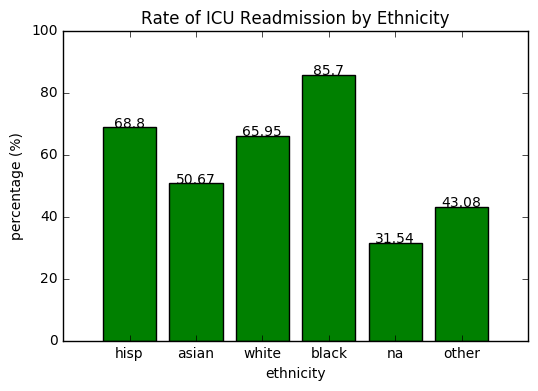

In [23]:
x_eth = df_ethn_icu.ethnicity.values
y_eth = df_ethn_icu.readm_perc.values

plt.bar(range(6), y_eth, align='center', color='g')
plt.xlabel('ethnicity')
plt.ylabel('percentage (%)')
plt.ylim([0, 100.0])
plt.xticks(range(6), x_eth)

idx=0
for i, val in zip(x_eth, y_eth):
    plt.text(range(6)[idx], val,str(val), ha='center')
    idx+=1
plt.title('Rate of ICU Readmission by Ethnicity')
plt.show()

**Deceiving Raw Numbers**:  
From examination of the raw values, patients of `white` and `african american` ethnicities appear to be more prone to readmission into the ICU (multiple ICU stays). Yet that may not be the case as the demographic of the dataset's population appear to primarily be of those two ethnicities (*oversampling*).

**Percentages**:  
Proportions of readmission rate (percentage) may be more appropriate to draw insights on the rate of ICU readmissions by each ethnicity.
  * `African Americans/Blacks` are the leading group for ICU readmission (85.70%)
  

### Age
Explore the relationship between age of ICU readmitted patients and their respective frequency of ICU readmissions.

In [24]:
# Unique patients admitted into ICU -- filter
q_uniq_icupat = """SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id"""
uniq_icupat = exec_query(q_uniq_icupat, False)
df_uniq_icupat = pd.DataFrame(uniq_icupat, columns=['subjectid', 'n_icustays'])

# filter for unique ICU patients (subject_id)
icu_filter = list(df_uniq_icupat.subjectid) 
df_age_icu = df_age_hadm[df_age_hadm.subjectid.isin(icu_filter)] # filter df of all patients

# Map number of ICU stays to patients
num_icu_map = df_uniq_icupat.set_index('subjectid').to_dict()['n_icustays'] # mapper dict
df_age_icu['n_icustays'] = df_age_icu.subjectid.map(num_icu_map)
df_age_icu['age'] = df_age_icu.age.astype(np.int) # change astype of age
df_age_icu

# df_age_icu.duplicated(subset='subjectid', keep='first').sum() # n duplicate patients (multiple HADM)

/home/cpnguyen/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/cpnguyen/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,subjectid,age,n_icustays
0,88,28,1
1,91,81,2
2,94,74,2
3,94,75,2
4,95,44,1
5,96,38,1
6,102,0,1
7,103,60,2
8,103,60,2
9,105,35,2


In [25]:
df_age_readm = df_age_icu[df_age_icu.n_icustays > 1]
df_age_readm[['age', 'n_icustays']].describe()

,age,n_icustays
count,20465.000000,20465.000000
mean,63.300415,3.809431
std,18.081454,3.976283
min,0.000000,2.000000
25%,53.000000,2.000000
50%,65.000000,3.000000
75%,77.000000,4.000000
max,101.000000,41.000000


In [71]:
dup_readm = df_age_readm.duplicated(subset='subjectid', keep='first').sum()
print "Number of ICU Patients with ICU Readmissions = %d" % df_age_readm.shape[0]
print "Number of Duplicate ICU Patients with ICU Readm = %d" % dup_readm

Number of ICU Patients with ICU Readmissions = 20465
Number of Duplicate ICU Patients with ICU Readm = 11710


##### Side Notes
  * 46476 *Unique* ICU Patients
  * 20465 *Total* Patients readmitted into the ICU
  * 11710 Duplicate ICU Patients
  * 8755 *Unique* ICU Patients with ICU Readmissions
     * n<sub>total ICU readmissions</sub> - n<sub>duplicate ICU patients readmitted</sub>

#### Filter Outliers of Minors

In [26]:
df_adult_readm = df_age_readm[df_age_readm.age > 17]
df_adult_readm[['age', 'n_icustays']].describe()

,age,n_icustays
count,20110.000000,20110.000000
mean,64.411984,3.840278
std,16.167290,4.004231
min,18.000000,2.000000
25%,54.000000,2.000000
50%,66.000000,3.000000
75%,77.000000,4.000000
max,101.000000,41.000000


In [72]:
print "Diff in Average Age = %.2f" % (df_adult_readm.age.mean() - df_age_readm.age.mean())
print "Diff in Average ICU Readmissions = %.2f" % (df_adult_readm.n_icustays.mean() - df_age_readm.n_icustays.mean())

Diff in Average Age = 1.11
Diff in Average ICU Readmissions = 0.03


Omission of outliers (newborn & adolescents), the difference in average age and number of ICU readmissions of patients are minimal.

#### Correlation: Age vs. n<sub>ICU readmission</sub>

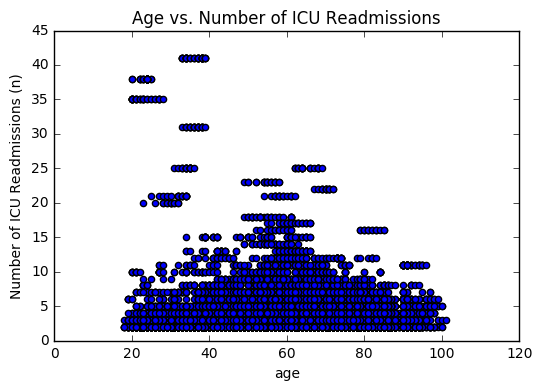

In [27]:
plt.scatter(df_adult_readm.age, df_adult_readm.n_icustays)
plt.xlabel('age')
plt.ylabel('Number of ICU Readmissions (n)')
# plt.ylim([0,20])
plt.title('Age vs. Number of ICU Readmissions')
plt.show()

  * Younger patients tend to have a higher frequency of ICU readmissions.
  * No overarching correlation trend between the number of ICU readmissions & age.

In [74]:
df_adult_readm.corr(method='pearson').loc['age', 'n_icustays']

-0.21562995294475379

A correlation analysis demonstrates that there is a **very weak negative correlation** between the number of ICU readmissions and the patients' age (Pearson correlation coefficient = -0.22).

### ICU LOS
Explore relationship between LOS in the ICU & ICU readmission.

In [86]:
# query
q_iculos_readm = """SELECT subject_id, AVG(los), COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id;"""

# Query output
iculos_r = exec_query(q_iculos_readm, False)
df_iculos_r = pd.DataFrame(iculos_r, 
                          columns=['subjectid', 'avg_los', 'n_icustays'])
df_iculos_readm = df_iculos_r[df_iculos_r.n_icustays > 1]
df_iculos_readm.loc[:,['avg_los', 'n_icustays']].describe()

,avg_los,n_icustays
count,8755.000000,8755.000000
mean,4.663188,2.719703
std,5.545796,1.692967
min,0.033950,2.000000
25%,1.831500,2.000000
50%,2.932750,2.000000
75%,5.274958,3.000000
max,89.541500,41.000000


**Conclusions**:
  * Average ICU LOS is 4.66 days.
  * Majority of ICU stays can be expected to deviate 5.55 days from the mean (4.66 days).
  * Potential Outlier: LOS = 89.54 days (big difference from 50% & 75% quartiles)

#### Correlation: Avg ICU LOS vs. n<sub>ICU stay</sub>

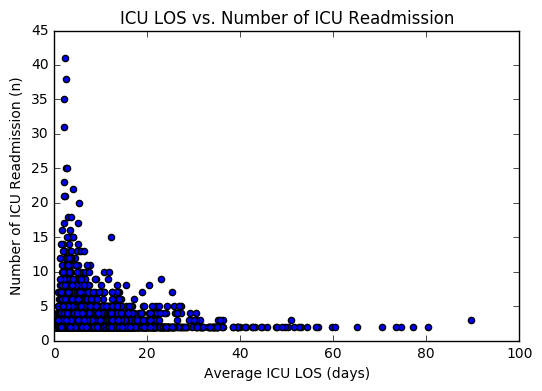

In [94]:
plt.scatter(df_iculos_readm.avg_los, df_iculos_readm.n_icustays)
plt.xlabel('Average ICU LOS (days)')
plt.ylabel('Number of ICU Readmission (n)')
plt.xlim([0, 100])
plt.title('ICU LOS vs. Number of ICU Readmission')
plt.show()

In [90]:
df_iculos_readm.corr(method='pearson').loc['avg_los', 'n_icustays']

-0.00059867026623559166

There appears to be very little, if any, correlation between the average ICU length of stay and number of ICU readmissions. The Pearson correlation coefficient value of -0.0006 supports the inference from the scatter plot. 

### First Care Units
Explore which First (Critical) Care Units are more susceptible to ICU readmissions.

In [182]:
# query
q_cu = """SELECT subject_id, first_careunit, last_careunit
    FROM icustays;"""

# Query output
cu = exec_query(q_cu, False)
df_cu = pd.DataFrame(cu, 
                           columns=['subjectid', 'first_cu', 'last_cu'])

# filter for ICU patients
filter_preadm = list(df_icu_pat.patientid)
df_cu_readm = df_cu[df_cu.subjectid.isin(filter_preadm)]

# map number of ICU readm to each patient
num_icur_map = df_icu_pat.set_index('patientid').to_dict()['n_icustay']
num_icur = pd.Series(df_cu_readm.subjectid.map(num_icur_map), name='n_icustays')
df_cu_readm = pd.concat([df_cu_readm, num_icur], axis=1)

# Number of ICU readmitted patients per CU
fcu_ct = df_cu_readm['subjectid'].groupby(df_cu_readm['first_cu']).agg('count')
lcu_ct = df_cu_readm['subjectid'].groupby(df_cu_readm['last_cu']).agg('count')
fcu_ct.name = 'fcu_n_icustays'
lcu_ct.name = 'lcu_n_icustays'

# Extract percentages
fcur_perc = (fcu_ct / fcu_ct.sum() * 100).round(decimals=2)
fcur_perc.name = 'fcu_perc'
lcur_perc = (lcu_ct / lcu_ct.sum() * 100).round(decimals=2)
lcur_perc.name = 'lcu_perc'

df_cu_readm1 = pd.concat([fcu_ct, lcu_ct, fcur_perc, lcur_perc], axis=1)
df_cu_readm1

,fcu_n_icustays,lcu_n_icustays,fcu_perc,lcu_perc
CCU,3449,3385,14.48,14.22
CSRU,3175,3132,13.33,13.15
MICU,10917,11052,45.85,46.42
NICU,454,454,1.91,1.91
SICU,3962,4080,16.64,17.13
TSICU,1854,1708,7.79,7.17


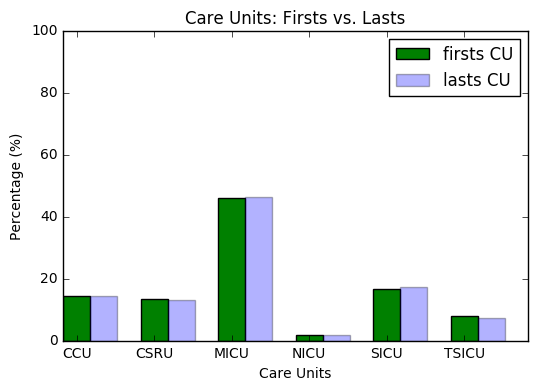

In [218]:
fig, ax = plt.subplots()
index = np.arange(6)
bar_width=0.35

rects1 = plt.bar(index, df_cu_readm1.fcu_perc, bar_width,
        alpha=1.0, color='g', label='firsts CU')
rects2 = plt.bar(index + bar_width, df_cu_readm1.lcu_perc, bar_width,
        alpha=0.3, color='b', label='lasts CU')
plt.xlabel('Care Units')
plt.ylabel('Percentage (%)')
plt.ylim([0, 100])
plt.xticks(index + bar_width/2, df_cu_readm1.index)
plt.legend()
plt.title('Care Units: Firsts vs. Lasts')
plt.show()

**Conclusions**:
  * There appears to be no diffence between the number of ICU readmissions and type of care units, *whether `admitted` (first CU) or `discharged` (last CU) into the ICU*.
  * `MICU` is the leading care unit, in both "firsts" & "lasts", for the number of ICU readmissions.

## Potential Exclusions
### 1. Patients with Negative LOS 
Potential organ donors

In [28]:
q_neglos = """SELECT subject_id, los FROM
    (SELECT *, EXTRACT(minute FROM (dischtime-admittime)) AS los
    FROM admissions) AS sub_q
WHERE LOS < 0;"""
neglos = exec_query(q_neglos, False)
df_neglos = pd.DataFrame(neglos, columns=['patient_id', 'los'])
df_neglos.head()

,patient_id,los
0,417,-57.0
1,181,-20.0
2,516,-8.0
3,1334,-43.0
4,1381,-25.0


In [29]:
df_neglos.shape

(98, 2)

98 patients that have a negative length of stay.

### 2. Age < 14
Missing data of patients between the ages of 0 and 14.

In [30]:
miss_age=df_age_hadm[df_age_hadm.age < 15]
miss_age.age.value_counts().sort_index()

0     8110
14       1
Name: age, dtype: int64

Newborn babies have different physiology from adults and may have different factors for ICU readmission.

Also, small sample size may limit validity of inferences.

In [31]:
newborn = df_age_hadm[df_age_hadm.age < 1]
newborn.shape[0]

8110

### 3. Missing Previous Care Unit 
Prior to transfer to another Care Unit or from the normal ward.

In [32]:
q_prevcu = """SELECT prev_careunit, count(*) 
FROM transfers GROUP BY prev_careunit;"""
prevcu = exec_query(q_prevcu, False)
df_prevcu = pd.DataFrame(prevcu, columns=['unit', 'n_transf'])
df_prevcu.sort_values('n_transf', ascending=False)

,unit,n_transf
3,,165888
0,MICU,26398
6,NICU,18631
4,CSRU,14322
2,SICU,11321
7,CCU,9534
1,NWARD,8297
5,TSICU,7506
